In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Convolution2D
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import scipy.stats as stats


In [3]:
# Step 1: Load Data
cols = ['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('data/WISDM_ar_v1.1_raw.txt', sep=',', on_bad_lines='skip', names=cols)
df = df.dropna()
df['z-axis'] = df['z-axis'].str.rstrip(';').astype(float)

In [4]:
# Step 2: Extract User 8's Data
df_8 = df[df['user'] == 8]

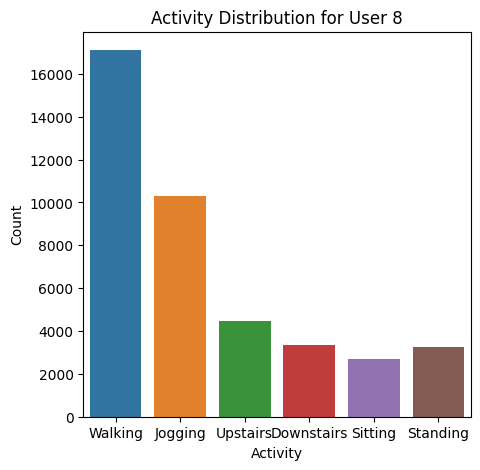

In [5]:
# Step 3: Visualize Activity Distribution
plt.figure(figsize=(5, 5))
sns.countplot(x='activity', data=df_8, hue='activity')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.title('Activity Distribution for User 8')
plt.show()

In [6]:
# Step 4: Balance the Data (Already balanced in the given data)
Walking = df_8[df_8['activity'] == 'Walking'].head(4800)
Jogging = df_8[df_8['activity'] == 'Jogging'].head(4800)
Upstairs = df_8[df_8['activity'] == 'Upstairs'].head(4800)
Downstairs = df_8[df_8['activity'] == 'Downstairs'].head(4800)
Sitting = df_8[df_8['activity'] == 'Sitting'].head(4800)
Standing = df_8[df_8['activity'] == 'Standing'].head(4800)
balanced_df_8 = pd.concat([Walking, Jogging, Upstairs, Downstairs, Sitting, Standing])


In [7]:
# Step 5: Encode Labels
label = LabelEncoder()
balanced_df_8['label'] = label.fit_transform(balanced_df_8['activity'])

In [8]:
# Step 6: Standardize Features
scaler = StandardScaler()
X = balanced_df_8[['x-axis', 'y-axis', 'z-axis']]
X = scaler.fit_transform(X)

In [9]:

scaled_X = pd.DataFrame(data=X, columns=['x-axis', 'y-axis', 'z-axis'])
scaled_X['label'] = balanced_df_8['label'].values

In [10]:
scaled_X.shape

(23367, 4)

In [11]:
label.classes_

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype=object)

In [12]:
# Step 7: Create Overlapping Windows
def get_windows(df, window_size, step_size):
    windows, labels = [], []
    num_features = 3
    for i in range(0, len(df) - window_size, step_size):
        xs = df['x-axis'].values[i: i + window_size]
        ys = df['y-axis'].values[i: i + window_size]
        zs = df['z-axis'].values[i: i + window_size]
        label = stats.mode(df['label'][i: i + window_size])[0]
        windows.append([xs, ys, zs])
        labels.append(label)
    windows = np.asarray(windows).reshape(-1, window_size, num_features)
    labels = np.asarray(labels)
    return windows, labels

In [13]:
# Create windows with a size of 100 and a step of 50
window_size, step_size = 100, 50
x, y = get_windows(scaled_X, window_size, step_size)

In [14]:
x.shape, y.shape

((466, 100, 3), (466,))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0, stratify=y)

In [16]:
# Reshape data for CNN
X_train = X_train.reshape(-1, window_size, 3, 1)
X_test = X_test.reshape(-1, window_size, 3, 1)

In [17]:
# Step 9: Define CNN Model
model = Sequential([
    Convolution2D(16, (2, 2), activation='relu', input_shape=X_train[0].shape),
    Dropout(0.1),
    Convolution2D(32, (2, 2), activation='relu'),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')  # 6 classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Step 10: Train the Model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32, verbose=1)


Epoch 1/10


/opt/anaconda3/envs/ml-project-tf_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3530 - loss: 1.5104 - val_accuracy: 0.7872 - val_loss: 0.7610
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7252 - loss: 0.7205 - val_accuracy: 0.8511 - val_loss: 0.4289
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8007 - loss: 0.4655 - val_accuracy: 0.8723 - val_loss: 0.3068
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8881 - loss: 0.3158 - val_accuracy: 0.8936 - val_loss: 0.2907
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8820 - loss: 0.2875 - val_accuracy: 0.9043 - val_loss: 0.2460
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9087 - loss: 0.2363 - val_accuracy: 0.9043 - val_loss: 0.2278
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9323 - loss: 0.1866 - val_accuracy: 0.9574 - val_loss: 0.2308
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9416 - loss: 0.1811 - val_accuracy: 0.9255 - val_loss: 0.2098
E

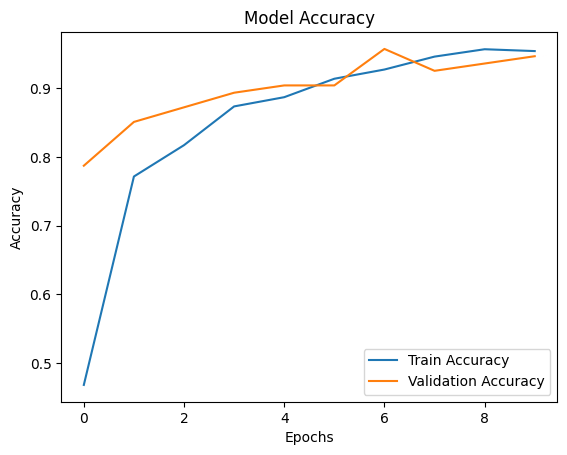

In [18]:
# Step 11: Visualize Training Performance
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


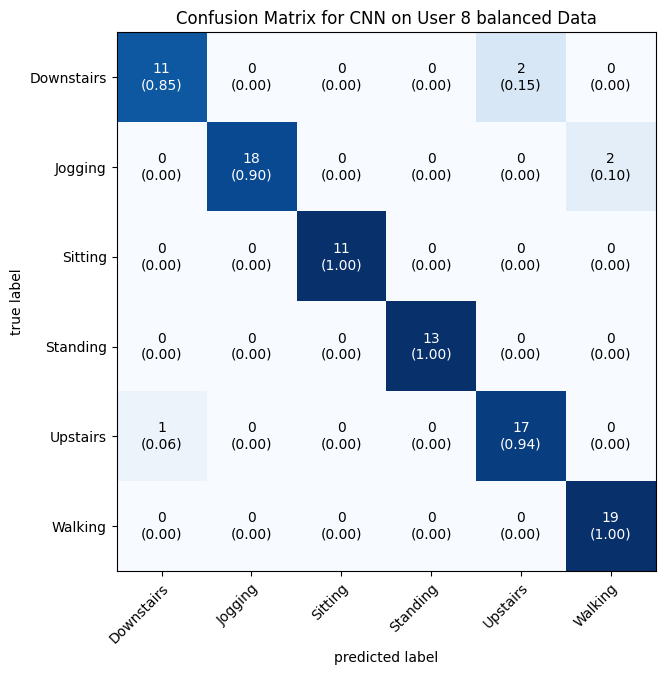

In [21]:
# Step 12: Evaluate Model with Confusion Matrix
y_pred = np.argmax(model.predict(X_test), axis=-1)
matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=matrix, class_names=label.classes_, show_normed=True, figsize=(7, 7))
plt.title('Confusion Matrix for CNN on User 8 balanced Data')
plt.show()
